
# BYO Tweets and predict your Myers-Briggs Personality Type

---

**Why yet another kernel that explores the Myers-Briggs Personality Type Dataset?**

- Exploring use of NLTK and XGBoost. 
- Practicing with the learnings from "[XGBoost With Python Mini-Course](https://machinelearningmastery.com/xgboost-python-mini-course/)".
- Trying out to build a model for each type indicator individually.
- And finally, predicting my own Myers-Briggs Personality Type.


### Outline

1. Data preview - distribution and correlation.
1. Data preparation - process posts, vectorize with count and tf-idf.
1. Apply steps of the "[XGBoost With Python Mini-Course](https://machinelearningmastery.com/xgboost-python-mini-course/)".
1. Predict own Myers-Briggs Personality Type base on a few tweets and blog post. 

---
**My playground:**
[Utilizing-the-Kaggle-Python-Docker-Container-image](https://github.com/stefan-bergstein/Utilizing-the-Kaggle-Python-Docker-Container-image)

---

This notebook is a fork from [Multiclass and multi-output classification](https://www.kaggle.com/depture/multiclass-and-multi-output-classification), [RNN mbti predictor](https://www.kaggle.com/prnvk05/rnn-mbti-predictor/) and [MBTI - Study personality
](https://www.kaggle.com/laowingkin/mbti-study-personality).

In [1]:
import pandas as pd
import numpy as np
import re

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# read data
data = pd.read_csv('../input/mbti_1.csv') 

## Data preview

In [2]:
data.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


### List of posts

In [3]:
[p.split('|||') for p in data.head(2).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

## Distribution of the MBTI personality types

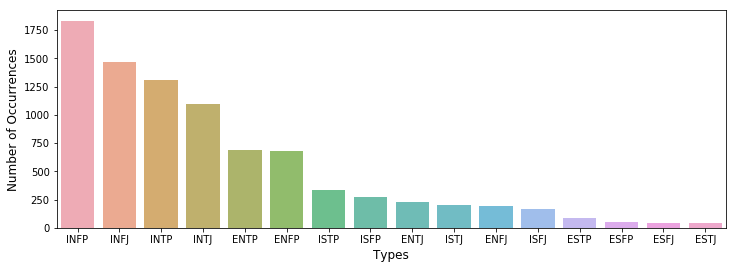

In [4]:
cnt_types = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

#### ... unbalanced occurrences. 

### Add columns for the type Indicators

In [5]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,JP,NS,TF
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [6]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) – Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) – Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) – Sensing (S):		 1197  /  7478
Thinking (T) – Feeling (F):		 4694  /  3981
Judging (J) – Perceiving (P):		 5241  /  3434


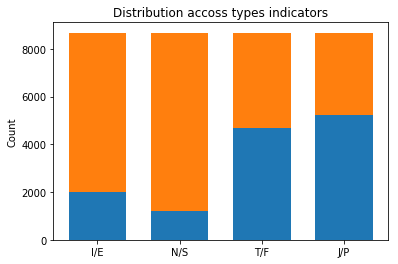

In [7]:
N = 4
but = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

### Pearson Features Correlation

In [8]:
data[['IE','NS','TF','JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,-0.069573,0.161939
NS,-0.045899,1.000000,-0.080954,0.014922
TF,-0.069573,-0.080954,1.000000,-0.004673
JP,0.161939,0.014922,-0.004673,1.000000




Unclear if the matrix shows anything valuable for interpretation.

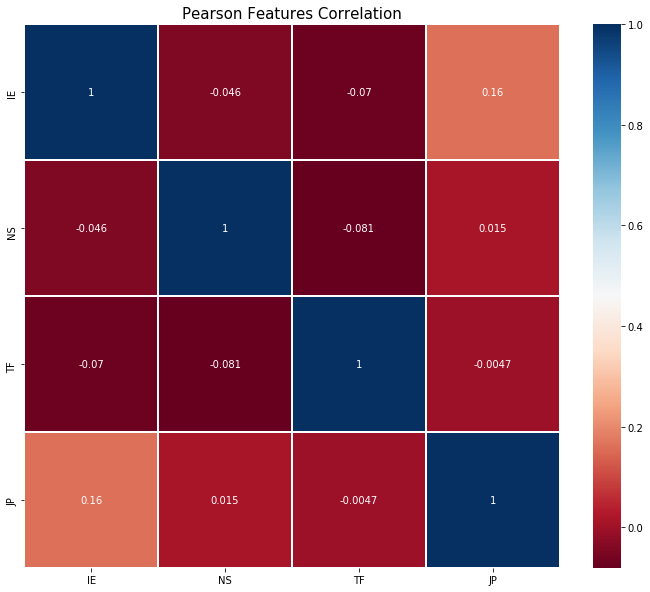

In [9]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Features Correlation', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

### Prep data

Binarize Type Indicator (better implemenation than mine above)

In [10]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

# Check ...
d = data.head(4)
list_personality_bin = np.array([translate_personality(p) for p in d.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 [0 0 1 0]]


### Preprocessing posts
* Remove urls 
* Keep only words and put everything lowercase
* Lemmatize each word 
* __Remove MBTI profiles strings. Too many appear in the posts!__

In [11]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [12]:
list_posts, list_personality  = pre_process_data(data, remove_stop_words=True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [13]:
print("Num posts and personalities: ",  list_posts.shape, list_personality.shape)

Num posts and personalities:  (8675,) (8675, 4)


In [14]:
list_posts[0]

'   moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello  sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video game growing current favorite video game cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo  lady complimentary personality well h

In [15]:
list_personality[0]

array([0, 0, 0, 0])

### Vectorize with count and tf-idf

Keep words appearing in 10% to 70 % of the posts.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("CountVectorizer...")
X_cnt = cntizer.fit_transform(list_posts)

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

print("Tf-idf...")
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer...
Tf-idf...


In [17]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names

[(0, 'ability'),
 (1, 'able'),
 (2, 'absolutely'),
 (3, 'accept'),
 (4, 'accurate'),
 (5, 'across'),
 (6, 'act'),
 (7, 'action'),
 (8, 'actual'),
 (9, 'actually'),
 (10, 'add'),
 (11, 'admit'),
 (12, 'advice'),
 (13, 'afraid'),
 (14, 'age'),
 (15, 'ago'),
 (16, 'agree'),
 (17, 'ah'),
 (18, 'almost'),
 (19, 'alone'),
 (20, 'along'),
 (21, 'already'),
 (22, 'although'),
 (23, 'amazing'),
 (24, 'amount'),
 (25, 'angry'),
 (26, 'animal'),
 (27, 'annoying'),
 (28, 'another'),
 (29, 'answer'),
 (30, 'anxiety'),
 (31, 'anymore'),
 (32, 'anyone'),
 (33, 'anything'),
 (34, 'anyway'),
 (35, 'apparently'),
 (36, 'appreciate'),
 (37, 'approach'),
 (38, 'area'),
 (39, 'argument'),
 (40, 'around'),
 (41, 'art'),
 (42, 'ask'),
 (43, 'asked'),
 (44, 'asking'),
 (45, 'aspect'),
 (46, 'assume'),
 (47, 'attention'),
 (48, 'attracted'),
 (49, 'avatar'),
 (50, 'avoid'),
 (51, 'aware'),
 (52, 'away'),
 (53, 'awesome'),
 (54, 'awkward'),
 (55, 'baby'),
 (56, 'back'),
 (57, 'bad'),
 (58, 'based'),
 (59, 'basi

In [18]:
X_tfidf.shape

(8675, 791)

## Train XGBoost classifiers

Practicing "XGBoost With Python Mini-Course" by jason@machinelearningmastery.com

[[1]](https://machinelearningmastery.com/xgboost-python-mini-course/) https://machinelearningmastery.com/xgboost-python-mini-course/

### X / Y data
- X: Posts in tf-idf representation
- Y: Binarized MBTI 

Note, here I trying out to build a model for each type indicator individually because I recall the multi-class / multi-out models in other notebooks weren't that accurate, right?



In [19]:
print("X: Posts in tf-idf representation \n* 1st row:\n%s" % X_tfidf[0])

X: Posts in tf-idf representation 
* 1st row:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.08042209  0.06830218  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.10331537  0.          0.04973404
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.10984584  0.          0.          0.          0.08642509  0.          0.
  0.10488948  0.          0.          0.          0.          0.
  0.05188886  0.06824736  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.      

In [20]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])


IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) – Sensing (S)
FT: Feeling (F) - Thinking (T)
JP: Judging (J) – Perceiving (P)


In [21]:
print("MBTI 1st row: %s" % translate_back(list_personality[0,:]))
print("Y: Binarized MBTI 1st row: %s" % list_personality[0,:])



MBTI 1st row: INFJ
Y: Binarized MBTI 1st row: [0 0 0 0]


## First XGBoost model for MBTI dataset


In [22]:
# First XGBoost model for MBTI dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))



IE: Introversion (I) / Extroversion (E) ...
* IE: Introversion (I) / Extroversion (E) Accuracy: 78.17%
NS: Intuition (N) – Sensing (S) ...
* NS: Intuition (N) – Sensing (S) Accuracy: 86.06%
FT: Feeling (F) - Thinking (T) ...
* FT: Feeling (F) - Thinking (T) Accuracy: 71.78%
JP: Judging (J) – Perceiving (P) ...
* JP: Judging (J) – Perceiving (P) Accuracy: 65.70%


## Monitor Performance and Early Stopping

*"XGBoost model can evaluate and report on the performance on a test set for the model during training. It supports this capability by specifying both a test dataset and an evaluation metric on the call to model.fit() when training the model and specifying verbose output (verbose=True). For example, we can report on the binary classification error rate (error) on a standalone test set (eval_set) while training an XGBoost model." [[1]](https://machinelearningmastery.com/xgboost-python-mini-course/)*

In [23]:
# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier()
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))
    
    

IE: Introversion (I) / Extroversion (E) ...
[0]	validation_0-logloss:0.662331
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.637307
[2]	validation_0-logloss:0.616979
[3]	validation_0-logloss:0.600483
[4]	validation_0-logloss:0.585568
[5]	validation_0-logloss:0.573552
[6]	validation_0-logloss:0.564016
[7]	validation_0-logloss:0.555667
[8]	validation_0-logloss:0.548621
[9]	validation_0-logloss:0.542487
[10]	validation_0-logloss:0.537856
[11]	validation_0-logloss:0.533571
[12]	validation_0-logloss:0.529929
[13]	validation_0-logloss:0.526731
[14]	validation_0-logloss:0.523933
[15]	validation_0-logloss:0.521377
[16]	validation_0-logloss:0.519125
[17]	validation_0-logloss:0.517464
[18]	validation_0-logloss:0.515545
[19]	validation_0-logloss:0.514147
[20]	validation_0-logloss:0.512725
[21]	validation_0-logloss:0.511898
[22]	validation_0-logloss:0.510745
[23]	validation_0-logloss:0.50952
[24]	validation_0-logloss:0.508703
[25]	validation_0-loglos

[24]	validation_0-logloss:0.617105
[25]	validation_0-logloss:0.615611
[26]	validation_0-logloss:0.614606
[27]	validation_0-logloss:0.612685
[28]	validation_0-logloss:0.611047
[29]	validation_0-logloss:0.609578
[30]	validation_0-logloss:0.608736
[31]	validation_0-logloss:0.607638
[32]	validation_0-logloss:0.606005
[33]	validation_0-logloss:0.604399
[34]	validation_0-logloss:0.603225
[35]	validation_0-logloss:0.601777
[36]	validation_0-logloss:0.600576
[37]	validation_0-logloss:0.599288
[38]	validation_0-logloss:0.598361
[39]	validation_0-logloss:0.59679
[40]	validation_0-logloss:0.595524
[41]	validation_0-logloss:0.594332
[42]	validation_0-logloss:0.593456
[43]	validation_0-logloss:0.59237
[44]	validation_0-logloss:0.591068
[45]	validation_0-logloss:0.589851
[46]	validation_0-logloss:0.588608
[47]	validation_0-logloss:0.587813
[48]	validation_0-logloss:0.586749
[49]	validation_0-logloss:0.585916
[50]	validation_0-logloss:0.585181
[51]	validation_0-logloss:0.584325
[52]	validation_0-logl

## Feature Importance with XGBoost

*"A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model. A trained XGBoost model automatically calculates feature importance on your predictive modeling problem." [[1]](https://machinelearningmastery.com/xgboost-python-mini-course/)*

#### Show feature importance plot and list for the first indicator:

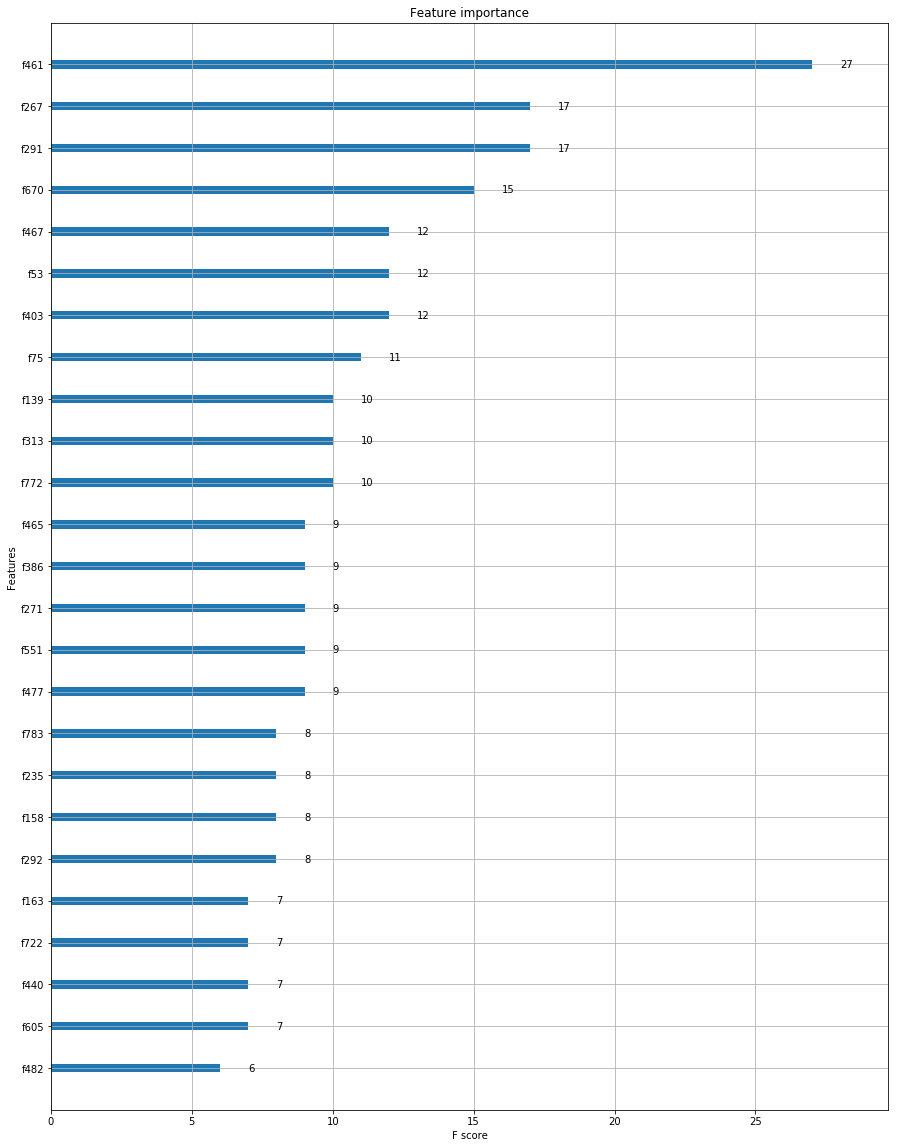

In [24]:
from xgboost import plot_importance

# Only the 1st indicator
y = list_personality[:,0]
# fit model on training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
ax = plot_importance(model, max_num_features=25)

fig = ax.figure
fig.set_size_inches(15, 20)

plt.show()

In [25]:
features = sorted(list(enumerate(model.feature_importances_)), key=lambda x: x[1], reverse=True)
for f in features[0:25]:
    print("%d\t%f\t%s" % (f[0],f[1],cntizer.get_feature_names()[f[0]]))
    
# Save xgb_params for late discussuin
default_get_xgb_params = model.get_xgb_params()

461	0.039074	ne
267	0.024602	fun
291	0.024602	guy
670	0.021708	super
53	0.017366	awesome
403	0.017366	lol
467	0.017366	ni
75	0.015919	bored
139	0.014472	crazy
313	0.014472	hey
772	0.014472	world
271	0.013025	game
386	0.013025	let
465	0.013025	new
477	0.013025	nt
551	0.013025	quiet
158	0.011577	debate
235	0.011577	family
292	0.011577	haha
783	0.011577	xd
163	0.010130	definitely
440	0.010130	mind
605	0.010130	shit
722	0.010130	turn
229	0.008683	eye


## How to Configure Gradient Boosting

*"A number of configuration heuristics were published in the original gradient boosting papers. 
They can be summarized as:*

- *Learning rate or shrinkage (learning_rate in XGBoost) should be set to 0.1 or lower, and smaller values will require the addition of more trees.*
- *The depth of trees (tree_depth in XGBoost) should be configured in the range of 2-to-8, where not much benefit is seen with deeper trees.*
- *Row sampling (subsample in XGBoost) should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling." [[1]](https://machinelearningmastery.com/xgboost-python-mini-course/)*

See also [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)


In [26]:
# Save xgb_params for later discussuin
default_get_xgb_params = model.get_xgb_params()
print (default_get_xgb_params)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


In [27]:
# setup parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))


IE: Introversion (I) / Extroversion (E) ...
* IE: Introversion (I) / Extroversion (E) Accuracy: 79.01%
NS: Intuition (N) – Sensing (S) ...
* NS: Intuition (N) – Sensing (S) Accuracy: 85.96%
FT: Feeling (F) - Thinking (T) ...
* FT: Feeling (F) - Thinking (T) Accuracy: 74.19%
JP: Judging (J) – Perceiving (P) ...
* JP: Judging (J) – Perceiving (P) Accuracy: 65.42%


## XGBoost Hyperparameter Tuning

*"The scikit-learn framework provides the capability to search combinations of parameters. This capability is provided in the GridSearchCV class and can be used to discover the best way to configure the model for top performance on your problem.*    

*The parameters to consider tuning are:*
- *The number and size of trees (n_estimators and max_depth).*
- *The learning rate and number of trees (learning_rate and n_estimators).*
- *The row and column subsampling rates (subsample, colsample_bytree and colsample_bylevel)." [[1]](https://machinelearningmastery.com/xgboost-python-mini-course/)*
    
See also [Introduction to gradient-boosted trees and XGBoost hyperparameters tuning](https://www.apprendimentoautomatico.it/en/introduction-to-gradient-boosted-trees-and-xgboost-hyperparameters-tuning-with-python/)    

**Note, Hyperparameter Tuning takes some time. You can skip to the next cell.**

In [28]:
# Tune learning_rate
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Posts in tf-idf representation
X = X_tfidf

# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2


# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]
    model = XGBClassifier(**param)
    
    param_grid = {
        'n_estimators' : [ 200, 300],
        'learning_rate': [ 0.2, 0.3]
        # 'learning_rate': [ 0.01, 0.1, 0.2, 0.3],
        # 'max_depth': [2,3,4],
    }
    
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, Y)

    # summarize results
    print("* Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("* %f (%f) with: %r" % (mean, stdev, param))


IE: Introversion (I) / Extroversion (E) ...
* Best: -0.495308 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.495308 (0.009734) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.497205 (0.010650) with: {'learning_rate': 0.2, 'n_estimators': 300}
* -0.501526 (0.013538) with: {'learning_rate': 0.3, 'n_estimators': 200}
* -0.508044 (0.016770) with: {'learning_rate': 0.3, 'n_estimators': 300}
NS: Intuition (N) – Sensing (S) ...
* Best: -0.381549 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.381549 (0.004793) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.392416 (0.009368) with: {'learning_rate': 0.2, 'n_estimators': 300}
* -0.399458 (0.009909) with: {'learning_rate': 0.3, 'n_estimators': 200}
* -0.421366 (0.010964) with: {'learning_rate': 0.3, 'n_estimators': 300}
FT: Feeling (F) - Thinking (T) ...
* Best: -0.522562 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.522562 (0.020541) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.524013 (0.023247) w

## Predict own Myers-Briggs Personality Type 

Using a few tweets and blog post, let's try to predict my own Myers-Briggs Personality Type.

1. Prep data
2. Fit and predict the 4 type indicators
3. Show result


#### Prep data:

In [29]:
# A few few tweets and blog post
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure.
"""

# The type is just a dummy so that the data prep fucntion can be reused
mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_data(mydata, remove_stop_words=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

1 of 1 rows


#### Fit and predict the 4 type indicators:

In [30]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

result = []
# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
    # print("* %s prediction: %s" % (type_indicators[l], y_pred))

IE: Introversion (I) / Extroversion (E) ...
NS: Intuition (N) – Sensing (S) ...
FT: Feeling (F) - Thinking (T) ...
JP: Judging (J) – Perceiving (P) ...


#### Here the result:

In [32]:
print("The result is: ", translate_back(result))

The result is:  INTJ


Wow, the result is very close to the real Myers-Briggs assessment that I did a few years back. Only one indicator is different. Any guess? ;-)
